# VGG (tf-keras)


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

tf_keras = tf.contrib.keras

# Model Hyperparameters

In [2]:
model_params = {
    "num_classes": 10, 
    "input_shape": (32, 32, 3), 
    "conv_kernel": (3,3), 
    "pool_kernel": (2,2), 
    "batch_size": 32 
}
hyper_params = {
    "l2_regularization": 0.0005,
    "dropout": 0.5, 
    "learning_rate": 0.0001  
}

In [3]:
# convolutional layer
def conv2d(filters):
    return tf_keras.layers.Conv2D(filters, # number of filters
                                  model_params["conv_kernel"], # kernel height and weight
                                  padding='same', 
                                  activation=tf.nn.relu,
                                  kernel_regularizer=
                                  tf.contrib.layers.l2_regularizer(hyper_params["l2_regularization"]))


In [4]:
# convLayer: conv - BN - conv - maxpool - dropout
def convLayer(filters, inputs):
    net = conv2d(filters)(inputs)
    net = tf_keras.layers.BatchNormalization()(net)
    net = conv2d(filters)(net)
    net = tf_keras.layers.MaxPool2D(model_params["pool_kernel"])(net)
    return tf_keras.layers.Dropout(0.25)(net)

In [5]:
# dense block
def denseLayer(units, inputs):
    net = tf_keras.layers.Dense(units)(inputs)
    return tf_keras.layers.Dropout(hyper_params["dropout"])(net)


# VGG Implementation

In [6]:
def VGG():

    # TensorFlow default graph
    tf.reset_default_graph()

    # input image tensor
    inputs = tf_keras.layers.Input(shape=model_params["input_shape"])

    # convolutional blocks
    # Block: conv - BN - conv - maxpool - dropout
    net = convLayer(64, inputs)
    net = convLayer(128, net)
    net = convLayer(256, net)

    net = tf_keras.layers.Flatten()(net)

    # fully connected blocks
    net = denseLayer(1024, net)
    net = denseLayer(512, net)

    # final layer
    outputs = tf_keras.layers.Dense(model_params["num_classes"],
                                    activation = tf.nn.softmax)(net)
    
    # model
    model = tf_keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

# Compile Model

### Add the loss function, the optimizer, and the metrics to the model.

In [7]:
def compile_model(model):
    
    # loss
    loss = tf_keras.losses.categorical_crossentropy

    # Adam optimizer
    optimizer = tf_keras.optimizers.Adam(lr=hyper_params["learning_rate"])
    
    # metrics
    metrics = [tf_keras.metrics.categorical_accuracy,
               tf_keras.metrics.top_k_categorical_accuracy]
    

    # compile the model with loss, optimizer and evaluation metrics
    model.compile(loss = loss,
                  optimizer = optimizer,
                  metrics = metrics)

    print(model.summary())
    
    return model

In [8]:
vgg = VGG()
vgg = compile_model(vgg)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
__________

# Load and Vectorize Cifar10 Dataset

In [9]:
# load Cifar dataset
(x_train, y_train), (x_test, y_test) = tf_keras.datasets.cifar10.load_data()

# Turn target values into one-hot encoded vectors
y_train = tf_keras.utils.to_categorical(y_train, model_params["num_classes"])
y_test = tf_keras.utils.to_categorical(y_test, model_params["num_classes"])

# Data Augmentation

In [10]:
# data generator augmentation configuration for training
train_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# data generator augmentation configuration for testing
# only rescaling
test_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

# Data Generators

In [11]:
# Training generator
train_generator = train_datagen.flow(x=x_train, y=y_train,
                                     batch_size=model_params["batch_size"])

# Testing generator
validation_generator = test_datagen.flow(x=x_test, y=y_test,
                                         batch_size=model_params["batch_size"])

# Train VGG on Cifar10

In [12]:
# fits the model on batches with real-time data augmentation
history = vgg.fit_generator(train_generator,
                            steps_per_epoch=300,#x_train.shape[0]//batch_size
                            epochs=10,
                            validation_data=validation_generator,
                            validation_steps=100)

Epoch 1/10
300/300 [==============================] - 11s - loss: 5.4328 - categorical_accuracy: 0.2080 - top_k_categorical_accuracy: 0.7010 - val_loss: 3.7603 - val_categorical_accuracy: 0.1153 - val_top_k_categorical_accuracy: 0.5869
Epoch 2/10
300/300 [==============================] - 13s - loss: 3.4022 - categorical_accuracy: 0.2594 - top_k_categorical_accuracy: 0.7712 - val_loss: 2.1970 - val_categorical_accuracy: 0.3000 - val_top_k_categorical_accuracy: 0.7828
Epoch 3/10
300/300 [==============================] - 13s - loss: 2.6392 - categorical_accuracy: 0.2818 - top_k_categorical_accuracy: 0.8086 - val_loss: 1.8888 - val_categorical_accuracy: 0.3571 - val_top_k_categorical_accuracy: 0.8775
Epoch 4/10
300/300 [==============================] - 13s - loss: 2.2890 - categorical_accuracy: 0.3168 - top_k_categorical_accuracy: 0.8347 - val_loss: 1.7337 - val_categorical_accuracy: 0.4197 - val_top_k_categorical_accuracy: 0.9141
Epoch 5/10
300/300 [==============================] - 13

# Evaluate Model Peformance

In [13]:
# evaluate the model on batches with real-time data augmentation
loss, acc, top_k_acc= vgg.evaluate_generator(validation_generator,
                                             steps = 200)
print("loss: {}".format(loss))
print("accuracy: {}".format(acc))
print("top 5 accuracy: {}".format(top_k_acc))

loss: 1.597713085045492
accuracy: 0.4956140350877193
top 5 accuracy: 0.9199561403508771


In [21]:
predictions = vgg.predict_generator(validation_generator, steps = 100)

In [15]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('vgg accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('vgg loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

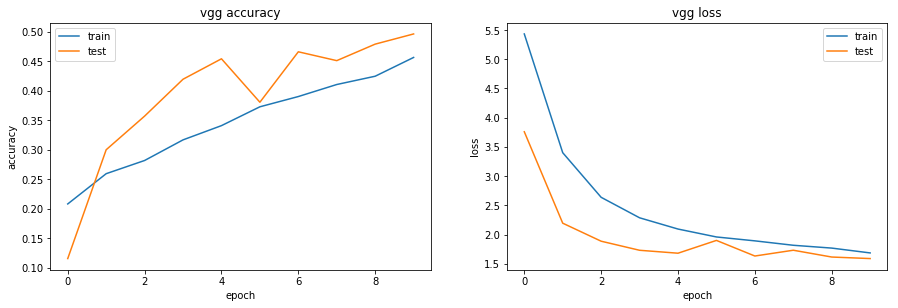

In [16]:
plot_accuracy_and_loss(history)

# Save Model Parameters

In [20]:
#save model
vgg_json = vgg.to_json()
open('cifar10_vgg.json', 'w').write(vgg_json)
vgg.save_weights('cifar10.h5', overwrite=True)